# Tiny Imagenet

In [1]:
from miniai.imports import *
from miniai.diffusion import *

from glob import glob
import shutil

In [2]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [3]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'bedroom'

In [4]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/bedroom.tgz', 'data')

In [5]:
bs = 256

In [6]:
def to_img(f): return (read_image(f, mode=ImageReadMode.RGB)/255-0.5)

In [7]:
class ImagesDS:
    def __init__(self, spec):
        self.path = Path(path)
        self.files = glob(str(spec), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        im = to_img(self.files[i])
        im = im[:, :256,:256]
        im = F.avg_pool2d(im, 4)
        return (im,)

In [8]:
tds = ImagesDS(path/'[1-9]'/f'**/*.jpg')
vds = ImagesDS(path/'0'/f'**/*.jpg')

In [9]:
def collate_ddpm(b): return noisify(default_collate(b)[0])

In [10]:
dls = DataLoaders(*get_dls(tds, vds, bs=bs, num_workers=fc.defaults.cpus, collate_fn=collate_ddpm))

In [11]:
class LearnEmbSS(nn.Module):
    def __init__(self, sz, ni):
        super().__init__()
        self.scale = nn.Parameter(torch.zeros(sz, ni))
        self.shift = nn.Parameter(torch.zeros(sz, ni))

    def forward(self, x): return x*self.scale + self.shift

In [12]:
def _mlp(ni, nh):
    return nn.Sequential(nn.Linear(ni,nh), nn.GELU(), nn.LayerNorm(nh), nn.Linear(nh,ni))

In [13]:
class EmbTransformerBlk(nn.Module):
    def __init__(self, n_emb, ni, attn_chans=8):
        super().__init__()
        self.attn = SelfAttention(ni, attn_chans=attn_chans, transpose=False)
        self.mlp = _mlp(ni, ni*4)
        self.nrm1 = nn.LayerNorm(ni)
        self.nrm2 = nn.LayerNorm(ni)
        self.emb_proj = nn.Linear(n_emb, ni*2)

    def forward(self, x, t):
        emb = self.emb_proj(F.silu(t))[:, None]
        scale,shift = torch.chunk(emb, 2, dim=2)
        x = x + self.attn(self.nrm1(x))
        x = x*(1+scale) + shift
        return x + self.mlp(self.nrm2(x))

In [14]:
class SimpleDiffusion(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1,
                 attn_chans=8, attn_start=1, n_mids=8):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        n = len(nfs)
        for i in range(n):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=n-1, num_layers=num_layers,
                                        attn_chans=0 if i<attn_start else attn_chans))

        self.le = LearnEmbSS(64, nf)
        self.mids = nn.ModuleList([EmbTransformerBlk(n_emb, nf) for _ in range(n_mids)])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(n):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=n-1, num_layers=num_layers+1,
                                    attn_chans=0 if i>=n-attn_start else attn_chans))
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t = inp
        temb = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(temb)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        n,c,h,w = x.shape
        x = self.le(x.reshape(n,c,-1).transpose(1,2))
        for block in self.mids: x = block(x, emb)
        x = x.transpose(1,2).reshape(n,c,h,w)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

In [15]:
def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [16]:
lr = 1e-3
epochs = 15
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = SimpleDiffusion(in_channels=3, out_channels=3, nfs=(32,256,384,512), num_layers=1, attn_chans=0, n_mids=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.177,0,train
0.094,0,eval
0.050,1,train
0.055,1,eval
0.042,2,train
0.040,2,eval
0.038,3,train
0.037,3,eval
0.035,4,train
0.034,4,eval


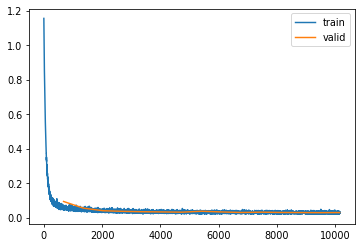

In [17]:
learn.fit(epochs)

In [18]:
torch.save(learn.model.state_dict(), 'models/lsun_diffusion-prog-64.pkl')

## Sampling

In [19]:
sz = (16,3,64,64)

In [20]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig, clamp=1.):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = (x_t-(1-abar_t).sqrt()*noise  )   / abar_t.sqrt()
    if clamp: x_0_hat = x_0_hat.clamp(-clamp,clamp)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

In [21]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=1.)

In [22]:
s = (preds[-1]+0.5)
# s = preds[-1]
s.min(),s.max(),s.shape

(tensor(-0.0660), tensor(1.0933), torch.Size([16, 3, 64, 64]))

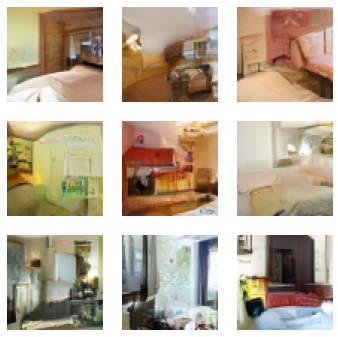

In [23]:
show_images(s[:9].clamp(0,1), imsize=2)